In [2]:
!pip3 install igraph

     |████████████████████████████████| 2.0 MB 3.6 MB/s eta 0:00:01


In [3]:
from igraph import *
import json
import random
import numpy as np
from numpy import linalg as LA
import itertools
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay  
import os
import pandas as pd
from copy import deepcopy
random.seed(2022)
np.random.seed(2022)

In [5]:
with open('los_angeles_censustracts.json') as f:
    census_tracts = json.loads(f.readline())

In [6]:
# Creating the dictionary storing the Unique IDs and the latitidue and longitude information
display_names = dict()
coordinates = dict()

for area in census_tracts['features']:
    id = int(area['properties']['MOVEMENT_ID'])
    display_name = area['properties']['DISPLAY_NAME']
    display_names[id] = display_name
    a = area['geometry']['coordinates'][0]
    coordinates[id] = np.array(a if type(a[0][0]) == float else a[0]).mean(axis=0)

In [7]:
# Printing some sample IDs and coordinates
for i in range(5):
    key = i + 1
    print('{}: {}, {}'.format(key, display_names[key], coordinates[key]))

1: Census Tract 480302, [-118.12053321   34.10309557]
2: Census Tract 480303, [-118.13785063   34.09645121]
3: Census Tract 480304, [-118.13138209   34.09626386]
4: Census Tract 480400, [-118.13224544   34.10349303]
5: Census Tract 480500, [-118.14492317   34.0986815 ]


In [8]:
# Creating the undirected graph
g = Graph(directed=False)
g.add_vertices(len(display_names))
g.vs['display_name'] = list(display_names.values())  # index = id - 1
g.vs['coordinates'] = list(coordinates.values())

In [10]:
# Reading in the mean travel times from the csv files
month_filter = {12}  # for monthly aggregate data of 4th quarter, we can filter data based off of only December

edges = []
weights = []

with open('los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv') as f:
    f.readline()  # skip the first line
    
    while True:
        line = f.readline()
        if line == '':
            break  # end of file
        
        vals = line.strip().split(',')
        
        # read edge info
        src, dest, month, dist = int(vals[0]), int(vals[1]), int(vals[2]), float(vals[3])

        # if data is not relevant, skip it
        if month not in month_filter:
            continue
            
        edges.append((src - 1, dest - 1))
        weights.append(dist)  

In [12]:
# Adding weighted edges to the graph
g.add_edges(edges)
g.es['weight'] = weights

QUESTION 9: Report the number of nodes and edges in G.

In [13]:
# Keeping only the giant connected component
components = g.components()
gcc = max(components, key=len)
vs_to_delete = [i for i in range(len(g.vs)) if i not in gcc]
g.delete_vertices(vs_to_delete)

# Removing the duplicate edges
g = g.simplify(combine_edges=dict(weight='mean')) 

In [14]:
print(len(g.vs), len(g.es))

2649 1003858


QUESTION 10: Build a minimum spanning tree (MST) of graph G. Report the street addresses near the two endpoints (the centroid locations) of a few edges. Are the results intuitive?

In [15]:
# Building a minimum spanning tree
mst = g.spanning_tree(weights=g.es['weight'])

# Printing some sample edges
edf = mst.get_edge_dataframe()
edf.head()

,source,target,weight
edge ID,,,
0,0,2,129.765
1,0,13,118.335
2,1,2,90.235
3,1,3,126.475
4,1,9,125.675


Need to find the centroids and the street addresses for these:

Vertex 0:

In [50]:
np.mean(census_tracts['features'][0]['geometry']['coordinates'][0], axis=0)

array([-118.12053321,   34.10309557])

Address from Google Maps: 823 E Grand Ave, Alhambra, CA 91801

Vertex 1:

In [56]:
np.mean(census_tracts['features'][1]['geometry']['coordinates'][0], axis=0)

array([-118.13785063,   34.09645121])

Address from Google Maps: 400 N Marguerita Ave, Alhambra, CA 91801

Vertex 2:

In [57]:
np.mean(census_tracts['features'][2]['geometry']['coordinates'][0], axis=0)

array([-118.13138209,   34.09626386])

Address from Google Maps: 211-299 W Woodward Ave, Alhambra, CA 91801

Vertex 3:

In [58]:
np.mean(census_tracts['features'][3]['geometry']['coordinates'][0], axis=0)

array([-118.13224544,   34.10349303])

Address from Google Maps: 830 N Garfield Ave, Alhambra, CA 91801

Vertex 9:

In [59]:
np.mean(census_tracts['features'][9]['geometry']['coordinates'][0], axis=0)

array([-118.14184446,   34.08538654])

Address from Google Maps: 500 S Marengo Ave, Alhambra, CA 91803

Vertex 13:

In [60]:
np.mean(census_tracts['features'][13]['geometry']['coordinates'][0], axis=0)

array([-118.11656383,   34.09585388])

Address from Google Maps: 308 S Cordova St, Alhambra, CA 91801

For edge ID 0, the distance is 0.8 miles.  
For edge ID 1, the distance is 0.6 miles.  
For edge ID 2, the distance is 0.7 miles.  
For edge ID 3, the distance is 0.9 miles.  
For edge ID 4, the distance is 1.0 miles.  
  
There looks to be a rough correspondence between the distances and the weights. Edges 0, 3, and 4 have weights in the 120s and those are the larger distances as well. Edges 1 and 2 have shorter distances and hence smaller weights. It's not a direct relation though since edge 1 has a larger weight than 2 and edge 4 has lower than edges 0 and 3. 

QUESTION 11: Determine what percentage of triangles in the graph (sets of 3 points on the map) satisfy the triangle inequality. You do not need to inspect all triangles, you can just estimate by random sampling of 1000 triangles.

In [16]:
# Helper functions for triangle inequality

def is_triangle(sides):
    smallest, medium, biggest = sorted(sides)
    return smallest + medium > biggest


def sample_triangles(g, n_samples):
    result = list()
    adjlist = [set(neis) for neis in g.get_adjlist()]
    
    while len(result) < n_samples:
        vertex = np.random.randint(len(g.vs))
        neis = adjlist[vertex]
        nei_pairs = list(itertools.combinations(neis, 2))
        if len(nei_pairs) == 0:
            continue
        nei_pair_ind = np.random.randint(len(nei_pairs))
        nei1, nei2 = nei_pairs[nei_pair_ind]
        if nei1 in adjlist[nei2]:
            result.append(tuple(sorted((vertex, nei1, nei2))))
                
    return result

In [17]:
n_samples = 1000
triangles = 0

for triangle_vs in sample_triangles(g, n_samples):
    
    edge_lengths = []
    
    for i in range(3):
        for j in range(i):
            edge_lengths.append(min(g.es.select(_between=([triangle_vs[i]], [triangle_vs[j]]))['weight']))   
            
    triangles += is_triangle(edge_lengths)
    
print('Triangle inequality holds by {}%'.format(round(100.0 * triangles / n_samples, 1)))

Triangle inequality holds by 90.8%


QUESTION 12: Find an upper bound on the empirical performance of the approximate algorithm:  
$\rho=\frac{Approximate TSP Cost}{Optimal TSP Cost}$

In [18]:
# Helper function

def preorder_traversal(root, root_parent=None):
    result = [root]
    
    for v in root.neighbors():
        if v == root_parent:
            continue
        result.extend(preorder_traversal(v, root))
        
    return result

In [20]:
tsp = [v.index for v in preorder_traversal(mst.vs[0])]
#print('IDs:\n' + '-' * 10 + '\n' + '\n'.join([mst.vs[i]['display_name'] for i in tsp]))

In [21]:
# Helper function for computing Approximate TSP cost
tsp_cost = 0
for i in range(len(tsp)):
    if i % 100 == 0:
        print(i)
        
    # below, the remainder is for circular indexing. i.e. the last element is connected back to the first element
    src, dest = tsp[i], tsp[(i + 1) % len(tsp)]
    direct_dists = g.es.select(_source=src, _target=dest)['weight']
    
    if direct_dists:  # if we directly have distance information
        tsp_cost += min(direct_dists)
    else:
        epath = mst.get_shortest_paths(v=src, to=dest, weights='weight', output='epath')[0]
        tsp_cost += sum([mst.es[i]['weight'] for i in epath])

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600


In [22]:
mst_cost = sum(mst.es['weight'])
print('MST Cost:', round(mst_cost))
print('TSP Cost:', round(tsp_cost))
print('Ratio:', round(tsp_cost/mst_cost, 2))

MST Cost: 269085
TSP Cost: 463638
Ratio: 1.72


QUESTION 13: Plot the trajectory that Santa has to travel!

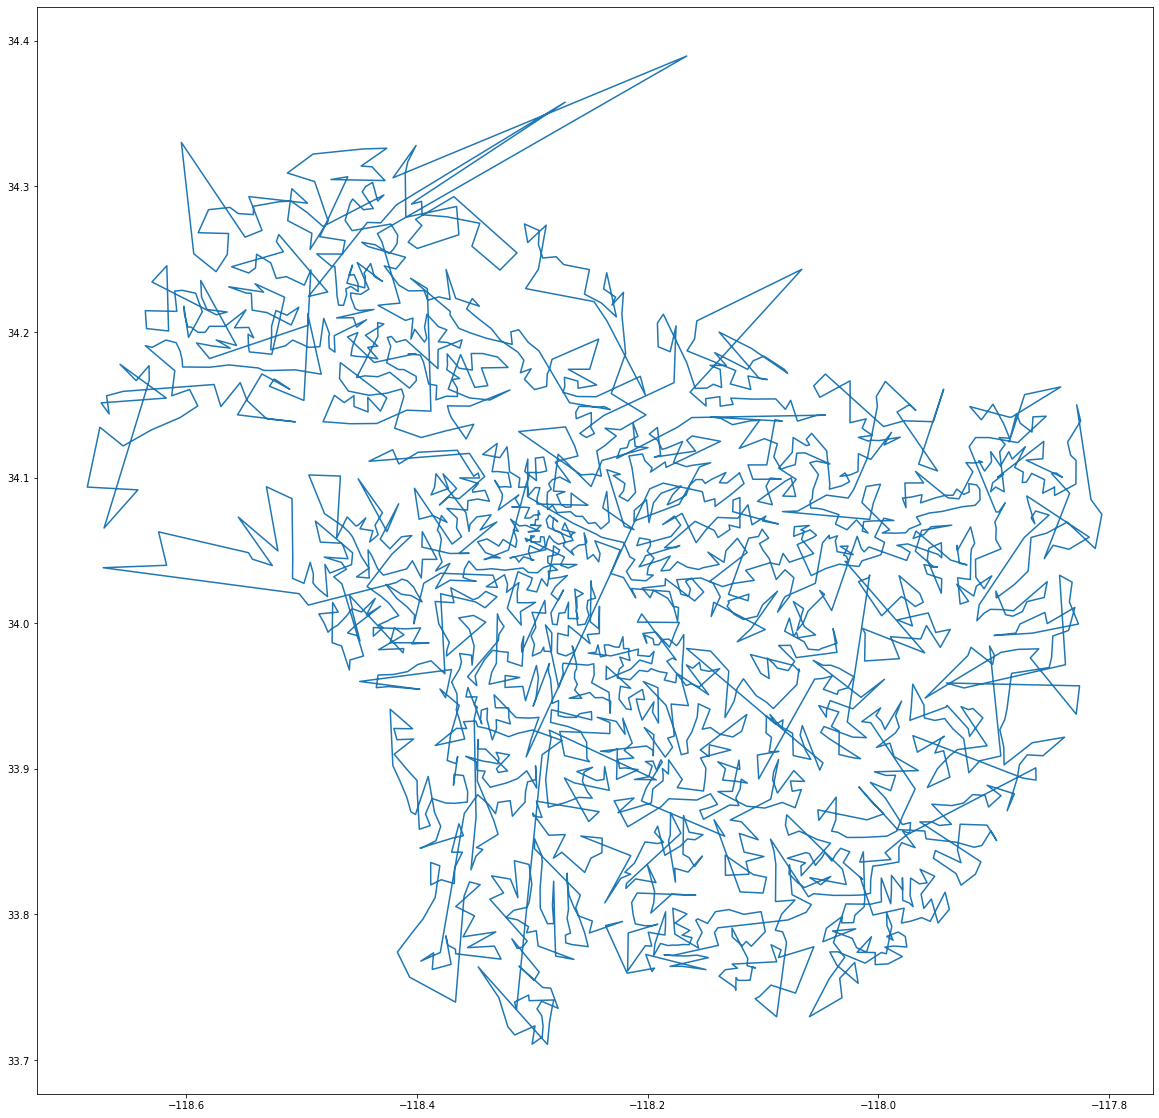

In [23]:
# Visualizing the route suggested by TSP
all_coordinates = np.array(g.vs['coordinates'])
tsp_coordinates = all_coordinates[tsp, :]
tsp_coordinates = np.vstack([tsp_coordinates, tsp_coordinates[0, :]])  # connect the last element back to the first element
plt.figure(figsize=(20,20))
plt.plot(tsp_coordinates[:, 0], tsp_coordinates[:, 1],'-')
plt.show()